In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name: ______________________
- PRN : ______________________
- Date: ______________________

# Image Processing with Neural Network

## Assignment A06 : 
## Working with PyTorch
- Custom DataSet with common transformation
- Activation function of your choice
- Regularization:
    - L2, 
    - BatchNorm,
    - Dropout, 
    - Early Stopping.
    
- multi-class output
- Fashion MNIST dataset

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
#import numpy as np
import pandas as pd
import sys
import numpy as np
from collections.abc import Callable
from typing import Literal


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
parent_dir = os.path.abspath('..')
sys.path.insert(0, parent_dir)
from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [3]:
###-----------------
### Global Variables
###-----------------
inpDir = os.path.join('..', 'input')
outDir = '../output'
modelDir = os.path.join('..', 'model')
subDir = 'fashion_mnist'
altName = 'A04_fashion_vanila'

EPOCHS = 2000
ALPHA = .001
TEST_SIZE = .2
PATIENCE = 20
LR_FACTOR = .2
LR_PATIENCE = 5

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.RandomState(RANDOM_STATE) # Set Random Seed for reproducible results
torch.manual_seed(RANDOM_STATE) ######

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)

## All about CUDA

In [4]:
# print ('Is CUDA available: ', torch.cuda.is_available())

# print ('CUDA version: ', torch.version.cuda )

# print ('Current Device ID: ', torch.cuda.current_device())

# print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

In [5]:
# torch.cuda.get_device_name(torch.cuda.current_device()) # to se which gpu we are running

In [6]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


In [7]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [8]:
class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [9]:
train_df['label'] = pd.to_numeric(train_df['label'], downcast = 'integer')
test_df['label'] = pd.to_numeric(test_df['label'], downcast = 'integer')
X_train = train_df.drop('label', axis = 1).to_numpy()
X_test = train_df.label

X_train, X_test, y_train, y_test = train_test_split(X_train, X_test, test_size = TEST_SIZE, stratify = X_test, random_state = RANDOM_STATE)

train_shape = X_train.shape

In [10]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [11]:
X_train.shape, y_train.shape

((48000, 784), (48000,))

In [12]:
## preparing model

In [13]:
input_dim = X_train.shape[1]

class Model(nn.Module): #nn.Module is pytorch class, we are extending it
    def __init__(self, input_dim):
        super(Model, self).__init__() #callling parent class constructot
        self.layer1 = nn.Linear(input_dim, 196) # incoming layer = input_dim no of neurons outgoing layer =196 no of neurons
        self.actv1 = nn.ReLU() # activation_function
        self.layer2 = nn.Linear(196, 98)
        self.actv2 = nn.ReLU()
        self.layer3 = nn.Linear(98, 10)

    def forward(self, x): # forward propagation
        x = self.layer1(x)
        x = self.actv1(x)
        x = self.layer2(x)
        x = self.actv2(x)
        x = self.layer3(x)
        return x

model = Model(input_dim).to(device = device)
print(model)
    



# model = nn.Sequential(nn.Linear(input_dim, 196),
#                       nn.ReLU(),
#                       nn.Linear(196, 98),
#                       nn.ReLU(),
#                       nn.Linear(98, 10)).to(device = device)

Model(
  (layer1): Linear(in_features=784, out_features=196, bias=True)
  (actv1): ReLU()
  (layer2): Linear(in_features=196, out_features=98, bias=True)
  (actv2): ReLU()
  (layer3): Linear(in_features=98, out_features=10, bias=True)
)


In [14]:
for param in list(model.parameters()):
    print(param.shape)

torch.Size([196, 784])
torch.Size([196])
torch.Size([98, 196])
torch.Size([98])
torch.Size([10, 98])
torch.Size([10])


In [15]:
# [196, 784] weight shape for layer 1
# similarly torch.Size([196]) : bias shape for layer 1 and so on 

In [16]:
train_X = torch.tensor(X_train, dtype = torch.float32, device = device)
train_y = torch.tensor(y_train, dtype = torch.int64, device = device)


test_X = torch.tensor(X_test, dtype = torch.float32, device = device)
test_y = torch.tensor(y_test.tolist(), dtype = torch.int64, device = device)

In [17]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

loss = []
tloss, n_epoch, acc, tacc = [],[],[],[]

for epoch in range(EPOCHS):
    model.train()

    predict_proba = model(train_X)
    curr_loss = loss_fn(predict_proba, train_y)

    optimizer.zero_grad()
    curr_loss.backward()
    optimizer.step()
    
    # Tracking if our model is working fine or not
    loss.append(curr_loss.data.item())
    y_pred = torch.argmax(predict_proba, dim = 1).cpu().numpy()
    curr_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
    acc.append(curr_acc)

    model.eval()
    test_proba = model(test_X)
    test_loss = loss_fn(test_proba, test_y)
    tloss.append(test_loss.data.item())


    y_pred = torch.argmax(test_proba, dim =1).cpu().numpy()
    test_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
    tacc.append(test_acc)
    n_epoch.append(epoch)


    if epoch % 500 == 0:
        print(f'Epoch: {epoch:>5d} |Loss: {curr_loss:.5f}/{test_loss:.5f} | ACC: {curr_acc: .5f}/{test_acc: .5f}')

Epoch:     0 |Loss: 2.31108/2.14537 | ACC:  0.07540/ 0.45983
Epoch:   500 |Loss: 0.04861/0.45206 | ACC:  0.98900/ 0.88592
Epoch:  1000 |Loss: 0.00863/0.65453 | ACC:  0.99985/ 0.88550
Epoch:  1500 |Loss: 0.00236/0.80669 | ACC:  1.00000/ 0.88558


In [18]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                        'loss': loss,
                        'test_loss' : tloss,
                        'acc' : acc,
                        'test_Acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_Acc
0,0,2.311084,2.145370,0.075396,0.459833
1,1,2.144453,1.991982,0.466729,0.551750
2,2,1.990149,1.832726,0.553729,0.597667
3,3,1.829995,1.668738,0.600729,0.611583
4,4,1.665122,1.509519,0.616458,0.617667


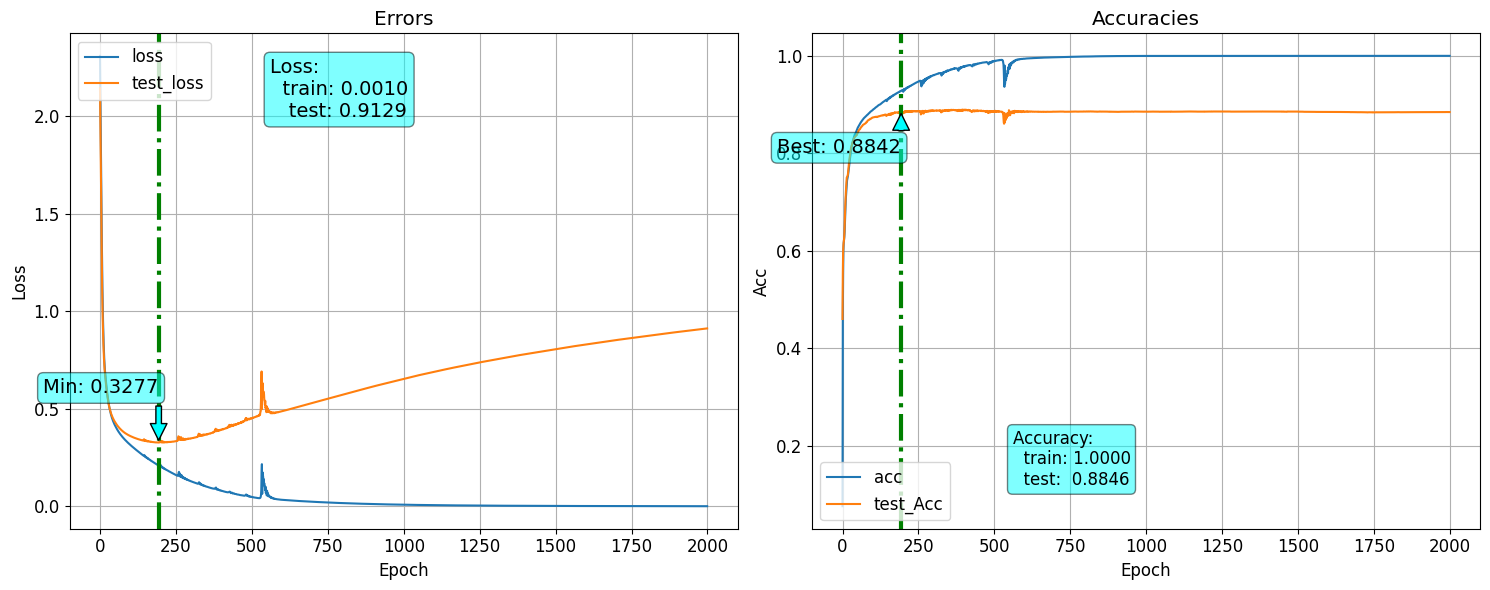

In [19]:
fn_plot_torch_hist(loss_df)

In [20]:
outputs = model(train_X)
outputs

tensor([[ 23.7138, -16.7399,  -4.0400,  ..., -10.0713, -13.7534, -22.0668],
        [ 16.7633, -20.3109,  10.7921,  ..., -18.8057, -10.6028, -21.5552],
        [-13.4144, -14.8306,  -0.6094,  ..., -15.5356, -15.9940, -23.5129],
        ...,
        [-14.1555,  -8.0640,  -1.9438,  ..., -20.0667,  -6.7636, -23.4932],
        [ -7.2807,  19.7282, -12.1281,  ..., -30.5218, -11.4416,  -5.3270],
        [ -4.4950, -22.0894,   3.3300,  ..., -23.8397, -21.4068, -25.2807]],
       grad_fn=<AddmmBackward0>)

In [21]:
type(outputs.cpu()) #.cpu() to bring it to cpu our is already on cpu

torch.Tensor

In [22]:
type(outputs.cpu().detach().numpy()) # did detach to detach from transformation : grad_fn=<AddmmBackward0>)
 # This means that the tensor is treated as a constant and no gradients will be calculated for it during backpropagation.

numpy.ndarray

In [23]:
# outputs = model(train_X)
y_pred = torch.argmax(outputs, dim = 1).numpy()
y_pred

array([0, 0, 6, ..., 4, 1, 6], dtype=int64)

In [24]:
y_true= train_y.numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4800
           1       1.00      1.00      1.00      4800
           2       1.00      1.00      1.00      4800
           3       1.00      1.00      1.00      4800
           4       1.00      1.00      1.00      4800
           5       1.00      1.00      1.00      4800
           6       1.00      1.00      1.00      4800
           7       1.00      1.00      1.00      4800
           8       1.00      1.00      1.00      4800
           9       1.00      1.00      1.00      4800

    accuracy                           1.00     48000
   macro avg       1.00      1.00      1.00     48000
weighted avg       1.00      1.00      1.00     48000



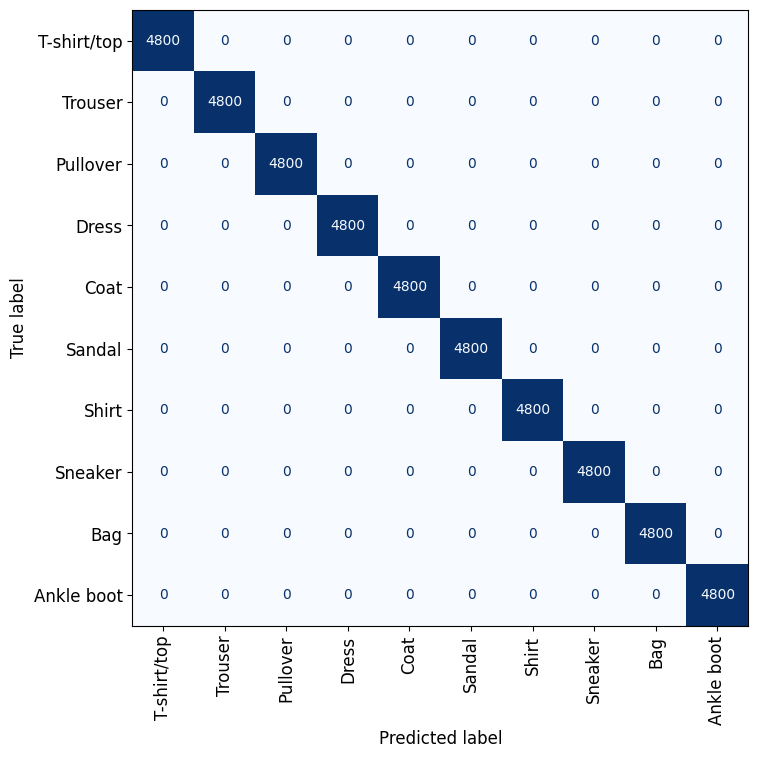

In [25]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = class_names.values())
disp.plot(cmap = 'Blues', xticks_rotation = 'vertical', colorbar = False)
plt.grid(False)

### on test data

In [26]:
outputs = model(test_X)
outputs

tensor([[-24.0380, -16.0307, -36.5395,  ...,   2.6660,  -8.8059,  21.0002],
        [-25.7890,  -9.8872, -21.0615,  ...,  24.5902,  -8.9631, -11.1382],
        [-39.1502, -17.3860,  -9.0264,  ..., -10.5539,  -5.7640, -24.1141],
        ...,
        [  8.5753, -23.0595,  -0.6946,  ..., -31.2026,  12.7004, -30.5601],
        [-12.1218, -13.6414,   7.5802,  ..., -18.4945,  -8.6717, -25.5591],
        [ -9.0319, -11.4760,   5.3348,  ..., -22.3447,  -9.1583, -22.1261]],
       grad_fn=<AddmmBackward0>)

In [27]:
type(outputs.cpu()) #.cpu() to bring it to cpu our is already on cpu

torch.Tensor

In [28]:
type(outputs.cpu().detach().numpy()) # did detach to detach from transformation : grad_fn=<AddmmBackward0>)
 # This means that the tensor is treated as a constant and no gradients will be calculated for it during backpropagation.

numpy.ndarray

In [29]:
# outputs = model(train_X)
y_pred = torch.argmax(outputs, dim = 1).numpy()
y_pred

array([9, 7, 5, ..., 8, 4, 4], dtype=int64)

In [30]:
outputs = model(test_X)
outputs

tensor([[-24.0380, -16.0307, -36.5395,  ...,   2.6660,  -8.8059,  21.0002],
        [-25.7890,  -9.8872, -21.0615,  ...,  24.5902,  -8.9631, -11.1382],
        [-39.1502, -17.3860,  -9.0264,  ..., -10.5539,  -5.7640, -24.1141],
        ...,
        [  8.5753, -23.0595,  -0.6946,  ..., -31.2026,  12.7004, -30.5601],
        [-12.1218, -13.6414,   7.5802,  ..., -18.4945,  -8.6717, -25.5591],
        [ -9.0319, -11.4760,   5.3348,  ..., -22.3447,  -9.1583, -22.1261]],
       grad_fn=<AddmmBackward0>)

In [31]:
type(outputs.cpu()) #.cpu() to bring it to cpu our is already on cpu

torch.Tensor

In [32]:
type(outputs.cpu().detach().numpy()) # did detach to detach from transformation : grad_fn=<AddmmBackward0>)
 # This means that the tensor is treated as a constant and no gradients will be calculated for it during backpropagation.

numpy.ndarray

In [33]:
# outputs = model(train_X)
y_pred = torch.argmax(outputs, dim = 1).numpy()
y_pred

array([9, 7, 5, ..., 8, 4, 4], dtype=int64)

In [34]:
y_true= test_y.numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1200
           1       0.99      0.98      0.98      1200
           2       0.82      0.83      0.82      1200
           3       0.89      0.89      0.89      1200
           4       0.81      0.83      0.82      1200
           5       0.95      0.96      0.95      1200
           6       0.73      0.68      0.71      1200
           7       0.94      0.94      0.94      1200
           8       0.97      0.95      0.96      1200
           9       0.95      0.94      0.94      1200

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.88      0.88      0.88     12000



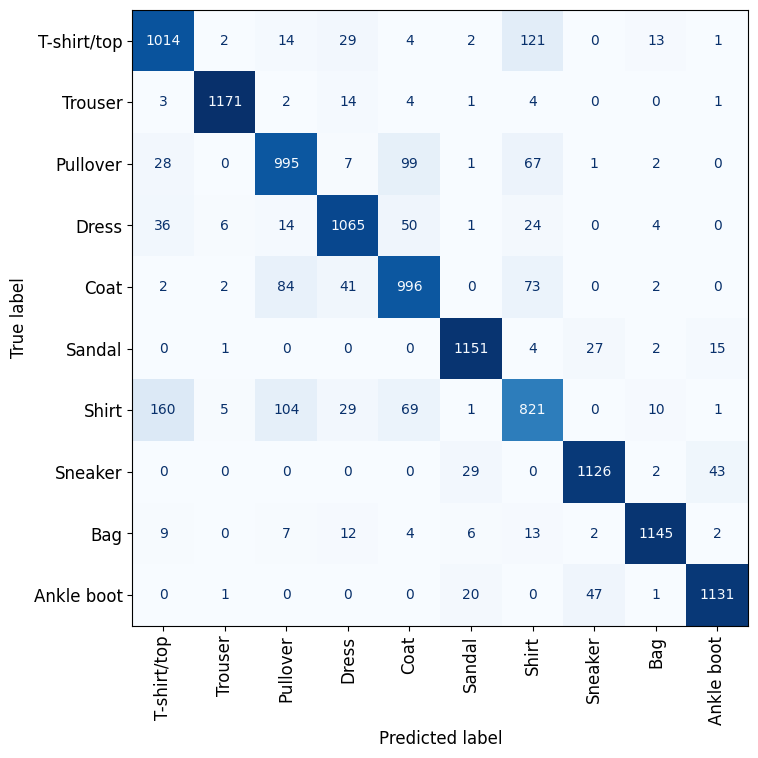

In [35]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = class_names.values())
disp.plot(cmap = 'Blues', xticks_rotation = 'vertical', colorbar = False)
plt.grid(False)